In [1]:
# Basic scientific python imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 
# Spikeinterface imports (could do this cleaner, oh well)
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.exporters as sxp
import spikeinterface.widgets as sw
import spikeinterface.full as si
import probeinterface as pi
import spikeinterface.curation as scur

# import spikeinterface_gui
# Core python imports
import os
import time
from pathlib import Path
from IPython.display import Audio

C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
## If reading series of intan recordings
# rec_name = '20220431_poke3_230421_155633'
# path_to_folder = os.normpath('C:/Users/lwood39/Documents/VNCMP/2023-05-20/' + rec_name)
path_to_folder = os.path.normpath(r'C:\Users\lwood39\Documents\VNCMP\2023-05-25\poke2_230525_123745')
dircontents = os.listdir(path_to_folder)
file_names = [x for x in dircontents if '.rhd' in x]
recording_list = []
for file in file_names:
    path_to_file = os.path.join(path_to_folder, file)
    recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='0'))
recording = si.concatenate_recordings(recording_list)
display(recording)

# rec_name = 'C:/Users/lwood39/Documents/VNCMP/2023-05-25-01/poke2_230525_160704'
# recording = se.IntanRecordingExtractor(rec_name, stream_id='0')
# recording = recording.frame_slice(start_frame=0, end_frame=int(231*30000))

# ## If reading open ephys recording session
# path_to_folder = Path('G:/SponbergLab/Data/Leo_2023-03-29_15-03-40/Record Node 103/experiment1')
# # path_to_folder = Path('G:/VNCMP/20230308/2023-03-08_13-08-30/Record Node 104')
# recording = se.read_openephys(path_to_folder, block_index=0, stream_id='0')
# recording = si.SelectSegmentRecording(recording, 0)

ConcatenateSegmentRecording: 32 channels - 30.0kHz - 1 segments - 18,002,688 samples 
                             600.09s (10.00 minutes) - uint16 dtype - 1.07 GiB

In [3]:
# Extract ADC channels, find times where camera trigger was pushed
ADC_recording_list = []
for file in file_names:
    path_to_file = os.path.join(path_to_folder, file)
    ADC_recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='3'))
ADC_recording = si.concatenate_recordings(ADC_recording_list)

trig = ADC_recording.get_traces(start_frame=0, end_frame=36000000, 
                                      return_scaled=True, 
                                      channel_ids=['35']) 
# In some recordings channel 35 is trigger, others 38
trig = trig > 3e6
np.where(np.logical_not(np.equal(np.roll(trig, 1), trig)))[0] / 30000

array([], dtype=float64)

In [4]:
# Remove analog input channels if present, not needed for spike sorting
if any('ADC' in s for s in recording.get_channel_ids()):  
    recording = recording.remove_channels([x for x in recording.get_channel_ids() if 'ADC' in x])
recording.get_channel_ids()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

<IPython.core.display.Javascript object>


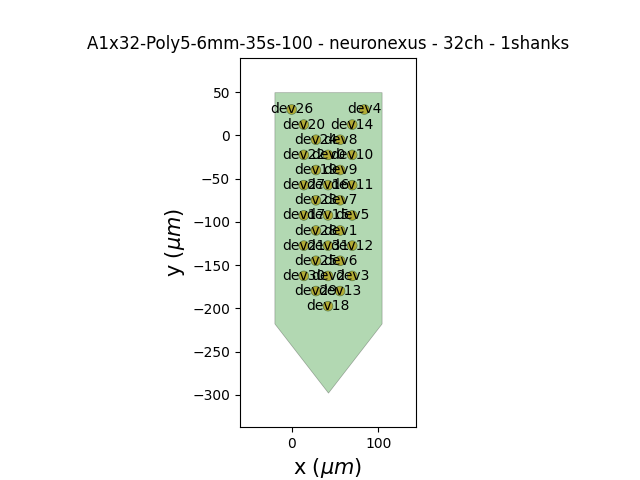

Probe - 32ch - 1shanks

In [5]:
probe = pi.read_probeinterface('A32_A1x32-Poly5-6mm-35s-100.json')
# probe = pi.read_probeinterface('CM32_A1x32-Poly5-6mm-35s-100.json')
pi.plotting.plot_probe(probe.probes[0], with_contact_id=True, with_device_index=True, show_channel_on_click=True)
# recording.set_probegroup(probe)
recording.set_probe(probe.probes[0], in_place=True)
recording.get_probe()

In [10]:
recording_filter = spre.bandpass_filter(recording, freq_min=300, freq_max=5000)
# recording_cache_filter = recording_filter.save(format='binary', n_jobs=8, chunk_duration='10s')

In [7]:
# recording_filter = spre.bandpass_filter(recording, freq_min=300, freq_max=5000)
# recording_whiten = spre.whiten(recording_filter, dtype='float32', mode='local', radius_um=25)
recording_zscore = spre.zscore(recording_filter, mode='mean+std')
recording_cache_preprocessed = recording_zscore.save(format='binary', n_jobs=8, chunk_duration='10s')
# recording_cache_preprocessed = recording_whiten.save(format='binary', n_jobs=8, chunk_duration='10s')
# recording_cache_raw = recording.save(format='binary', n_jobs=8, chunk_duration='10s')

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpkgurrnb7\B2VCNHTV
write_binary_recording with n_jobs = 8 and chunk_size = 300000


write_binary_recording:   0%|          | 0/61 [00:00<?, ?it/s]

In [11]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [12]:
import mountainsort5
mountainsort5.__version__

'0.4.1'

## Run Sorter

In [13]:
sorter = 'mountainsort5'
print(ss.get_default_sorter_params(sorter))
ss.get_sorter_params_description(sorter)

{'scheme': '2', 'detect_threshold': 5.5, 'detect_sign': -1, 'detect_time_radius_msec': 0.5, 'snippet_T1': 20, 'snippet_T2': 20, 'npca_per_channel': 3, 'npca_per_subdivision': 10, 'snippet_mask_radius': 250, 'scheme1_detect_channel_radius': 150, 'scheme2_phase1_detect_channel_radius': 200, 'scheme2_detect_channel_radius': 50, 'scheme2_max_num_snippets_per_training_batch': 200, 'scheme2_training_duration_sec': 300, 'scheme2_training_recording_sampling_mode': 'uniform', 'scheme3_block_duration_sec': 1800, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True}


{'scheme': "Which sorting scheme to use: '1, '2', or '3'",
 'detect_threshold': 'Detection threshold - recommend to use the default',
 'detect_sign': 'Use -1 for detecting negative peaks, 1 for positive, 0 for both',
 'detect_time_radius_msec': 'Determines the minimum allowable time interval between detected spikes in the same spatial region',
 'snippet_T1': 'Number of samples before the peak to include in the snippet',
 'snippet_T2': 'Number of samples after the peak to include in the snippet',
 'npca_per_channel': 'Number of PCA features per channel in the initial dimension reduction step',
 'npca_per_subdivision': 'Number of PCA features to compute at each stage of clustering in the isosplit6 subdivision method',
 'snippet_mask_radius': 'Radius of the mask to apply to the extracted snippets',
 'scheme1_detect_channel_radius': 'Channel radius for excluding events that are too close in time in scheme 1',
 'scheme2_phase1_detect_channel_radius': 'Channel radius for excluding events tha

In [16]:
params = ss.get_default_sorter_params(sorter)
params['scheme'] = '2'
# Parameters for any scheme
params['detect_sign'] = 1
params['detect_threshold'] = 3.0
params['snippet_T1'] = 30
params['snippet_T2'] = 30
params['npca_per_channel'] = 4
params['npca_per_subdivision'] = 25
params['detect_time_radius_msec'] = 0.5
# Parameters for scheme 2
params['scheme2_phase1_detect_channel_radius'] = None
params['scheme2_detect_channel_radius'] = None
params['snippet_mask_radius'] = 50#200
params['scheme2_training_duration_sec'] = int(0.4 * recording.get_duration())
params['scheme2_max_num_snippets_per_training_batch'] = 20000
# Parameters for scheme 3
params['scheme3_block_duration_sec'] = 300
# Don't filter or whiten. We do that ourselves to have better control 
params['whiten'] = False
params['filter'] = False

tic = time.perf_counter()
sort = ss.run_sorter(
    sorter,
    recording=recording_cache_preprocessed,
    output_folder=sorter,
#     docker_image="spikeinterface/" + sorter + "-compiled-base:latest",
    verbose=False,
    **params)
print(f'{time.perf_counter()-tic} seconds elapsed')
print(sort)
time.sleep(1)
Audio('notification-sound.wav', autoplay=True)

Using training recording of duration 240 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.569 seconds ***
Running phase 1 sorting
Number of channels: 32
Number of timepoints: 7200000
Sampling frequency: 30000.0 Hz
Channel 0: [ 42.  -22.5]
Channel 1: [  56. -110.]
Channel 2: [  42.  -162.5]
Channel 3: [  70.  -162.5]
Channel 4: [84. 30.]
Channel 5: [ 70.  -92.5]
Channel 6: [  56. -145.]
Channel 7: [ 56. -75.]
Channel 8: [56. -5.]
Channel 9: [ 56. -40.]
Channel 10: [ 70.  -22.5]
Channel 11: [ 70.  -57.5]
Channel 12: [  70.  -127.5]
Channel 13: [  56. -180.]
Channel 14: [70.  12.5]
Channel 15: [ 42.  -92.5]
Channel 16: [ 42.  -57.5]
Channel 17: [ 14.  -92.5]
Channel 18: [  42.  -197.5]
Channel 19: [ 28. -40.]
Channel 20: [14.  12.5]
Channel 21: [  14.  -127.5]
Channel 22: [ 14.  -22.5]
Channel 23: [ 28. -75.]
Channel 24: [28. -5.]
Channel 25: [  28. -145.]
Channel 26: [ 0. 30.]
Channel 27: [ 14.  -57.5]
Channel 28: [  28. -110.]
Cha

*** MS5 Elapsed time for SCHEME2 detecting spikes: 43.021 seconds ***
Extracting and classifying snippets
*** MS5 Elapsed time for SCHEME2 extracting and classifying snippets: 7.277 seconds ***
Updating events
Removing duplicates
*** MS5 Elapsed time for SCHEME2 updating events: 0.102 seconds ***
Time chunk 2 of 6
Loading traces
*** MS5 Elapsed time for SCHEME2 loading traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,

*** MS5 Elapsed time for SCHEME2 detecting spikes: 8.492 seconds ***
Extracting and classifying snippets
*** MS5 Elapsed time for SCHEME2 extracting and classifying snippets: 4.487 seconds ***
Updating events
Removing duplicates
*** MS5 Elapsed time for SCHEME2 updating events: 0.056 seconds ***
Time chunk 4 of 6
Loading traces
*** MS5 Elapsed time for SCHEME2 loading traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

*** MS5 Elapsed time for SCHEME2 detecting spikes: 9.010 seconds ***
Extracting and classifying snippets
*** MS5 Elapsed time for SCHEME2 extracting and classifying snippets: 5.959 seconds ***
Updating events
Removing duplicates
*** MS5 Elapsed time for SCHEME2 updating events: 0.066 seconds ***
Time chunk 6 of 6
Loading traces
*** MS5 Elapsed time for SCHEME2 loading traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

In [21]:
import mountainsort5 as ms5
timer = time.time()
ms5_params = ms5.Scheme2SortingParameters(
    detect_sign=1,
    detect_threshold=3.4,
    phase1_detect_time_radius_msec=1.0,
    phase1_detect_channel_radius=None,
    detect_time_radius_msec=0.5,
    detect_channel_radius=None,
    phase1_npca_per_channel=4,
    phase1_npca_per_subdivision=20,
    snippet_T1=30,
    snippet_T2=50,
    snippet_mask_radius=80,
    training_duration_sec=int(0.6 * recording.get_duration()),
    max_num_snippets_per_training_batch=20000,
#     classifier_npca=
)
sort = ms5.sorting_scheme2(
    recording=recording_cache_preprocessed,
    sorting_parameters=ms5_params
)
assert isinstance(sort, si.BaseSorting)
elapsed_sec = time.time() - timer
duration_sec = recording.get_total_duration()
print(sort)
print(f'Elapsed time for sorting: {elapsed_sec:.2f} sec') 
print(f'x{(duration_sec / elapsed_sec):.2f} speed compared with real time for {recording.get_num_channels()} channels')

Using training recording of duration 360 sec with the sampling mode initial
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.001 seconds ***
Running phase 1 sorting
Number of channels: 32
Number of timepoints: 10800000
Sampling frequency: 30000.0 Hz
Channel 0: [ 42.  -22.5]
Channel 1: [  56. -110.]
Channel 2: [  42.  -162.5]
Channel 3: [  70.  -162.5]
Channel 4: [84. 30.]
Channel 5: [ 70.  -92.5]
Channel 6: [  56. -145.]
Channel 7: [ 56. -75.]
Channel 8: [56. -5.]
Channel 9: [ 56. -40.]
Channel 10: [ 70.  -22.5]
Channel 11: [ 70.  -57.5]
Channel 12: [  70.  -127.5]
Channel 13: [  56. -180.]
Channel 14: [70.  12.5]
Channel 15: [ 42.  -92.5]
Channel 16: [ 42.  -57.5]
Channel 17: [ 14.  -92.5]
Channel 18: [  42.  -197.5]
Channel 19: [ 28. -40.]
Channel 20: [14.  12.5]
Channel 21: [  14.  -127.5]
Channel 22: [ 14.  -22.5]
Channel 23: [ 28. -75.]
Channel 24: [28. -5.]
Channel 25: [  28. -145.]
Channel 26: [ 0. 30.]
Channel 27: [ 14.  -57.5]
Channel 28: [  28. -110.]
Ch

*** MS5 Elapsed time for SCHEME2 detecting spikes: 34.276 seconds ***
Extracting and classifying snippets
*** MS5 Elapsed time for SCHEME2 extracting and classifying snippets: 7.127 seconds ***
Updating events
Removing duplicates
*** MS5 Elapsed time for SCHEME2 updating events: 0.051 seconds ***
Time chunk 2 of 6
Loading traces
*** MS5 Elapsed time for SCHEME2 loading traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,

*** MS5 Elapsed time for SCHEME2 detecting spikes: 5.855 seconds ***
Extracting and classifying snippets
*** MS5 Elapsed time for SCHEME2 extracting and classifying snippets: 3.783 seconds ***
Updating events
Removing duplicates
*** MS5 Elapsed time for SCHEME2 updating events: 0.020 seconds ***
Time chunk 4 of 6
Loading traces
*** MS5 Elapsed time for SCHEME2 loading traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

*** MS5 Elapsed time for SCHEME2 detecting spikes: 6.892 seconds ***
Extracting and classifying snippets
*** MS5 Elapsed time for SCHEME2 extracting and classifying snippets: 3.590 seconds ***
Updating events
Removing duplicates
*** MS5 Elapsed time for SCHEME2 updating events: 0.034 seconds ***
Time chunk 6 of 6
Loading traces
*** MS5 Elapsed time for SCHEME2 loading traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

In [37]:
sort_file_path = './test_sorting.npz'
se.NpzSortingExtractor.write_sorting(sort, sort_file_path)

In [38]:
job_kwargs = dict(n_jobs=8, chunk_duration="100s", progress_bar=True)

wave_extract = si.extract_waveforms(
    recording_cache_preprocessed,
    se.NpzSortingExtractor(sort_file_path),
#     sort,
    './waveforms',
    ms_before=1, ms_after=1,
    max_spikes_per_unit=100000,
    overwrite=True, 
    **job_kwargs)

extract waveforms memmap:   0%|          | 0/7 [00:00<?, ?it/s]

## Phy GUI

In [ ]:
# phy_save_path = './phy_folder/' + sorter + '_' + rec_name + '_zscore_fullRecording'
phy_save_path = os.path.join(os.path.dirname(path_to_folder), 'phy_folder',  os.path.basename(path_to_folder))
sxp.export_to_phy(wave_extract, 
                  phy_save_path, 
                  remove_if_exists=True)#,
#                   **job_kwargs)

# save record of params
with open(phy_save_path+'/params_log.txt', 'w') as f: 
    for key, value in params.items(): 
        f.write('%s:%s\n' % (key, value))
        
        

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/601 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/601 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/16 [00:00<?, ?it/s]

 To run Phy, use cmd or Powershell, and do one of the following:
 
 1. Run the command spit out by the cell above, often something like:
 
 ```phy template-gui  C:\Users\lwood39\Documents\AutoSpikeSort\phy_folder\mountainsort5_poke1_230520_153135\params.py```
 
 
 2. Navigate to phy_folder created by the above cell, then run phy command
 
 Example:
 
 ```cd C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder_kilosort```
 
 ```phy template-gui params.py```
 

## WHY IS IT CRASHING? Some general notes

I've noticed a few common patterns that will lead to crashes. Here are some notes on those, in no particular order.

- **Kilosort is crashing. Stack trace has something related to a gpuArray error, and/or mentions something like a nan**

  This almost always seems to be one of the batches of kilosort containing no detected spikes. Kilosort runs on independent "batches", sections of your data of a certain length. If one of those has no spikes, it seems to typically create a nan value that gums up the works. The easy solution is to either (a) Only feed in data that has spiking of some kind throughout, or (b) increase the batch size, with the 'NT' parameter

<IPython.core.display.Javascript object>


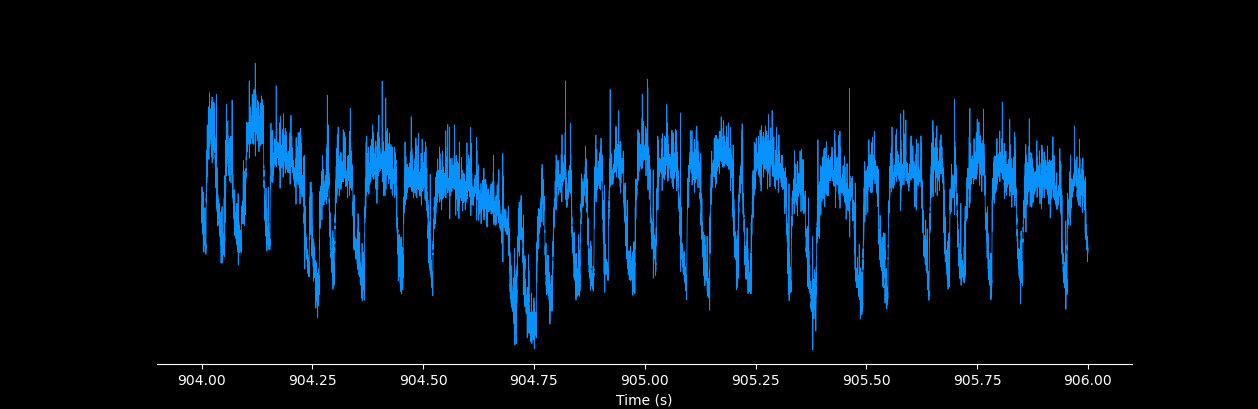

In [61]:
fs = 30000
times = (904, 906)
data = recording_cache_raw.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs),
    return_scaled=True, channel_ids=['3'])
data_filt = recording_cache_justfilter.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs),
    return_scaled=True, channel_ids=['3'])
time = np.arange(times[0], times[1], 1/fs)

plt.style.use("dark_background")
plt.figure()
plt.plot(time, data, '#0991FC', lw=0.6)
# plt.plot(time, data_filt, '#FF0201', alpha=0.9, lw=0.6)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Time (s)')
plt.show()

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpkufk0jqx\RDVYFDDZ
write_binary_recording with n_jobs = 8 and chunk_size = 300000


write_binary_recording:   0%|          | 0/7 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


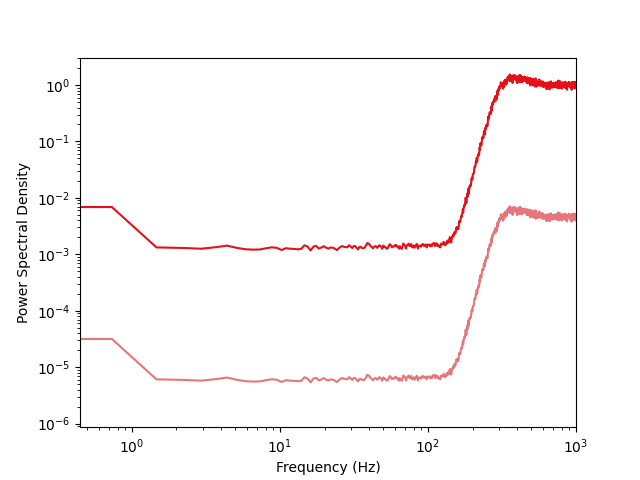

C:\Users\lwood39\AppData\Local\Temp\ipykernel_26700\579366111.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim((0, 1000))


In [68]:
from scipy import signal

fs = 30000

recording_filter = spre.bandpass_filter(recording, freq_min=300, freq_max=5000)
recording_whiten = spre.whiten(recording_filter, dtype='float32', mode='local', radius_um=10)
recording_cache_preprocessed = recording_whiten.save(format='binary', n_jobs=8, chunk_duration='10s')

times = (1, 59)
data = recording_cache_filter.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs), 
    return_scaled=True, channel_ids=['10'])

plt.figure()
f, Pxx_spec = signal.welch(data.flatten(), fs, 
                           nperseg=4096*10, 
                           scaling='density',
                           detrend=False)
plt.loglog(f, np.sqrt(Pxx_spec), '#E61019')

# times = (903.6, 906)
data_flap = recording_cache_preprocessed.get_traces(
    start_frame=int(times[0]*fs), end_frame=int(times[1]*fs), 
    return_scaled=True, channel_ids=['10'])
f, Pxx_spec = signal.welch(data_flap.flatten(), fs, 
                           nperseg=4096*10, 
                           scaling='density',
                           detrend=False)
plt.loglog(f, np.sqrt(Pxx_spec), '#E6767A')
plt.xlim((0, 1000))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.show()

## Spikeinterface GUI

In [ ]:
import spikeinterface_gui
os.chdir(Path('C:/Users/lwood39/Documents/AutoSpikeSort/'))
app = spikeinterface_gui.mkQApp()
win = spikeinterface_gui.MainWindow(wave_extract)
win.show()
app.exec()

You have 100000 in your WaveformExtractor, the display can be slow
You should re run the WaveformExtractor with max_spikes_per_unit=500
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)


C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\pyqtgraph\GraphicsScene\GraphicsScene.py:325: RuntimeWarning: Error sending drag event:
Traceback (most recent call last):
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever(

slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None

## Plot sandbox

<IPython.core.display.Javascript object>


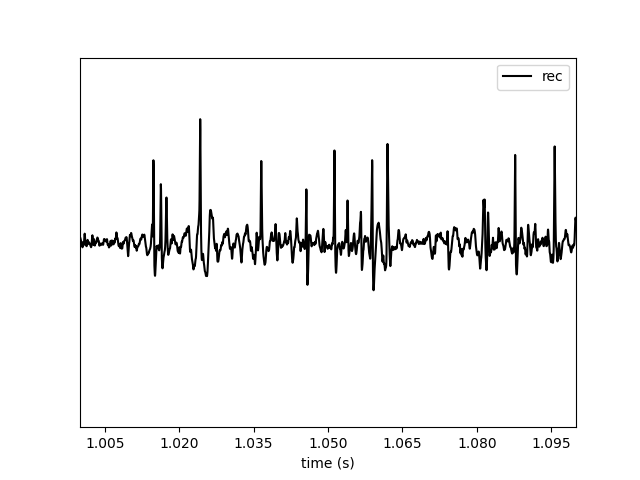

<IPython.core.display.Javascript object>


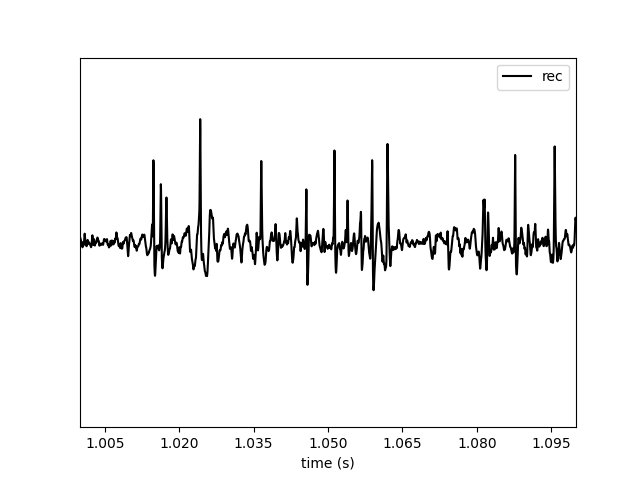

In [69]:
sw.plot_timeseries(recording_cache_filter, time_range=(1, 1.1), channel_ids=['0'], return_scaled=True)
sw.plot_timeseries(recording_cache_preprocessed, time_range=(1, 1.1), channel_ids=['0'], return_scaled=True)
plt.show()

<IPython.core.display.Javascript object>


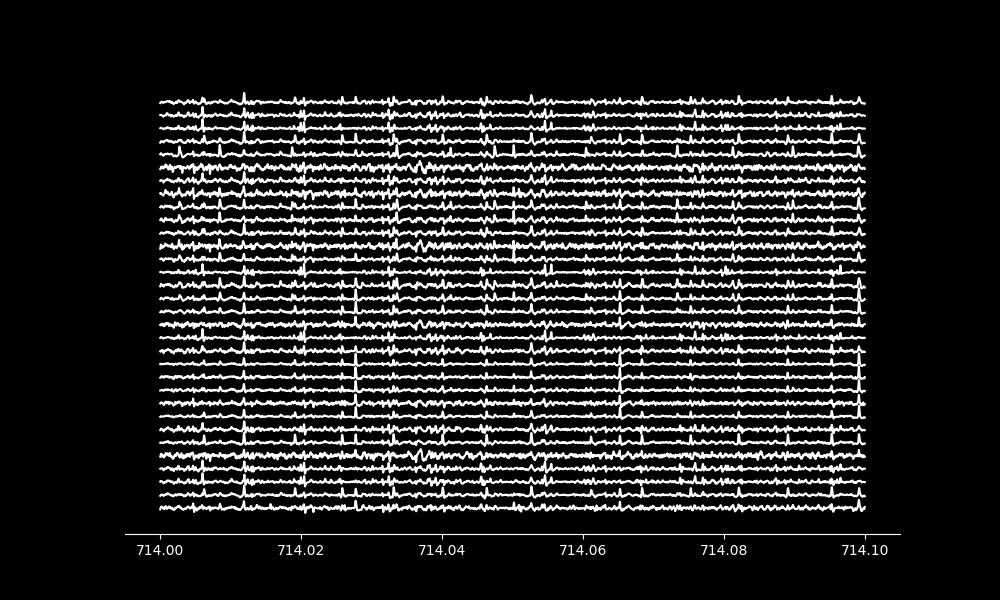

[]

In [127]:
data = recording_cache_preprocessed.get_traces(start_frame=714*30000, end_frame=int(714.15*30000), return_scaled=True, channel_ids=[str(i) for i in range(32)])
x = np.linspace(714, 714.1, data.shape[0])

plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
ax = plt.gca()
for i in range(32):
    ydat = data[:,i] / (np.max(data[:,i]) - np.min(data[:,i]))
    plt.plot(x, ydat + i, 'w')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_yaxis().set_ticks([])

<IPython.core.display.Javascript object>


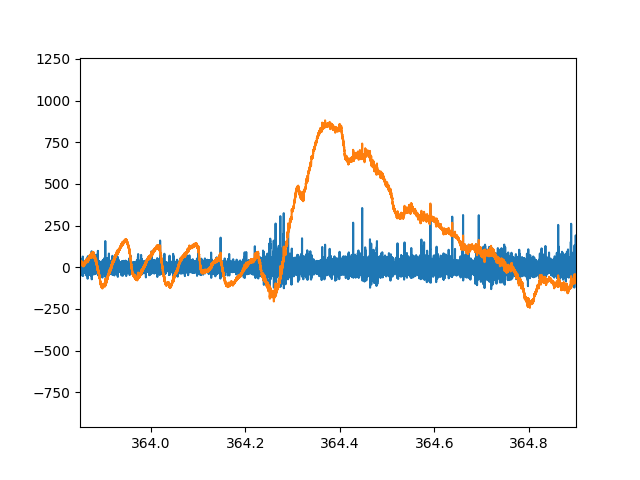

In [56]:
times = (300, 400)
data = recording_cache_justfilter.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
rawdata = recording_cache_raw.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
time = np.arange(times[0], times[1], 1/fs)
plt.figure()
plt.plot(time, data)
plt.xlim((363.85, 364.9))
# plt.show()

# plt.figure()
plt.plot(time, rawdata/5)
plt.xlim((363.85, 364.9))
plt.show()